# 导入包

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

D:\tensorflowtest\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\tensorflowtest\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\tensorflowtest\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\tensorflowtest\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a

In [2]:
tf.__version__

'1.14.0'

# 试验参数的赋值

In [3]:
%matplotlib inline
batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 3
epsilon_std = 1.0
noise_factor = 0.5

# 导入数据集

In [4]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 数据信息

In [70]:
x_train.shape

(60000, 28, 28, 1)

In [69]:
x_test.shape

(10000, 28, 28, 1)

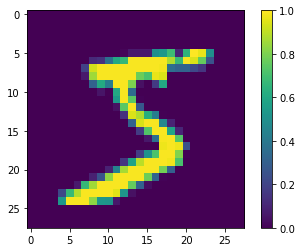

In [72]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
#数据预处理

将这些值缩小至 0 到 1 之间，除以 255。
然后将数据进行reshape

最后加入高斯噪声生成噪声数据，然后将其馈送到神经网络模型。
以相同的方式对训练集和测试集进行预处理：

In [ ]:
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

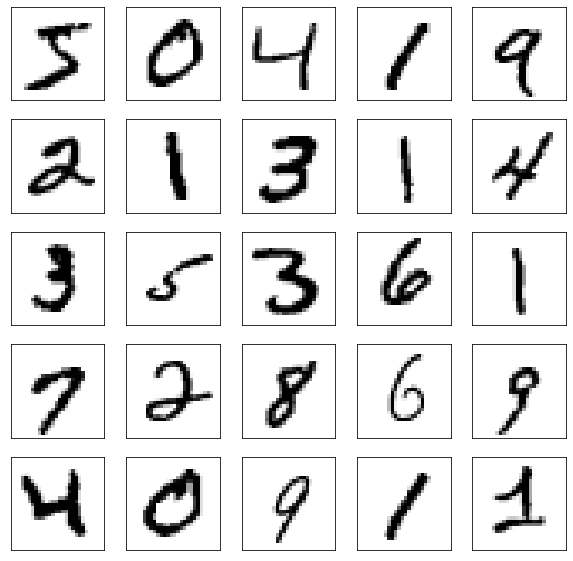

In [74]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.imshow(train_images[i])
    #plt.colorbar()
    #print(train_labels[1])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

加入随机高斯噪声后的数据展示

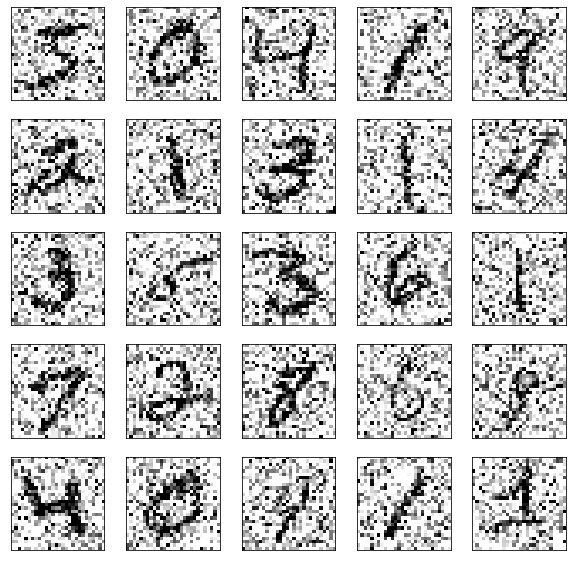

In [73]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noise_train[i], cmap=plt.cm.binary)
    #plt.imshow(train_images[i])
    #plt.colorbar()
    #print(train_labels[1])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

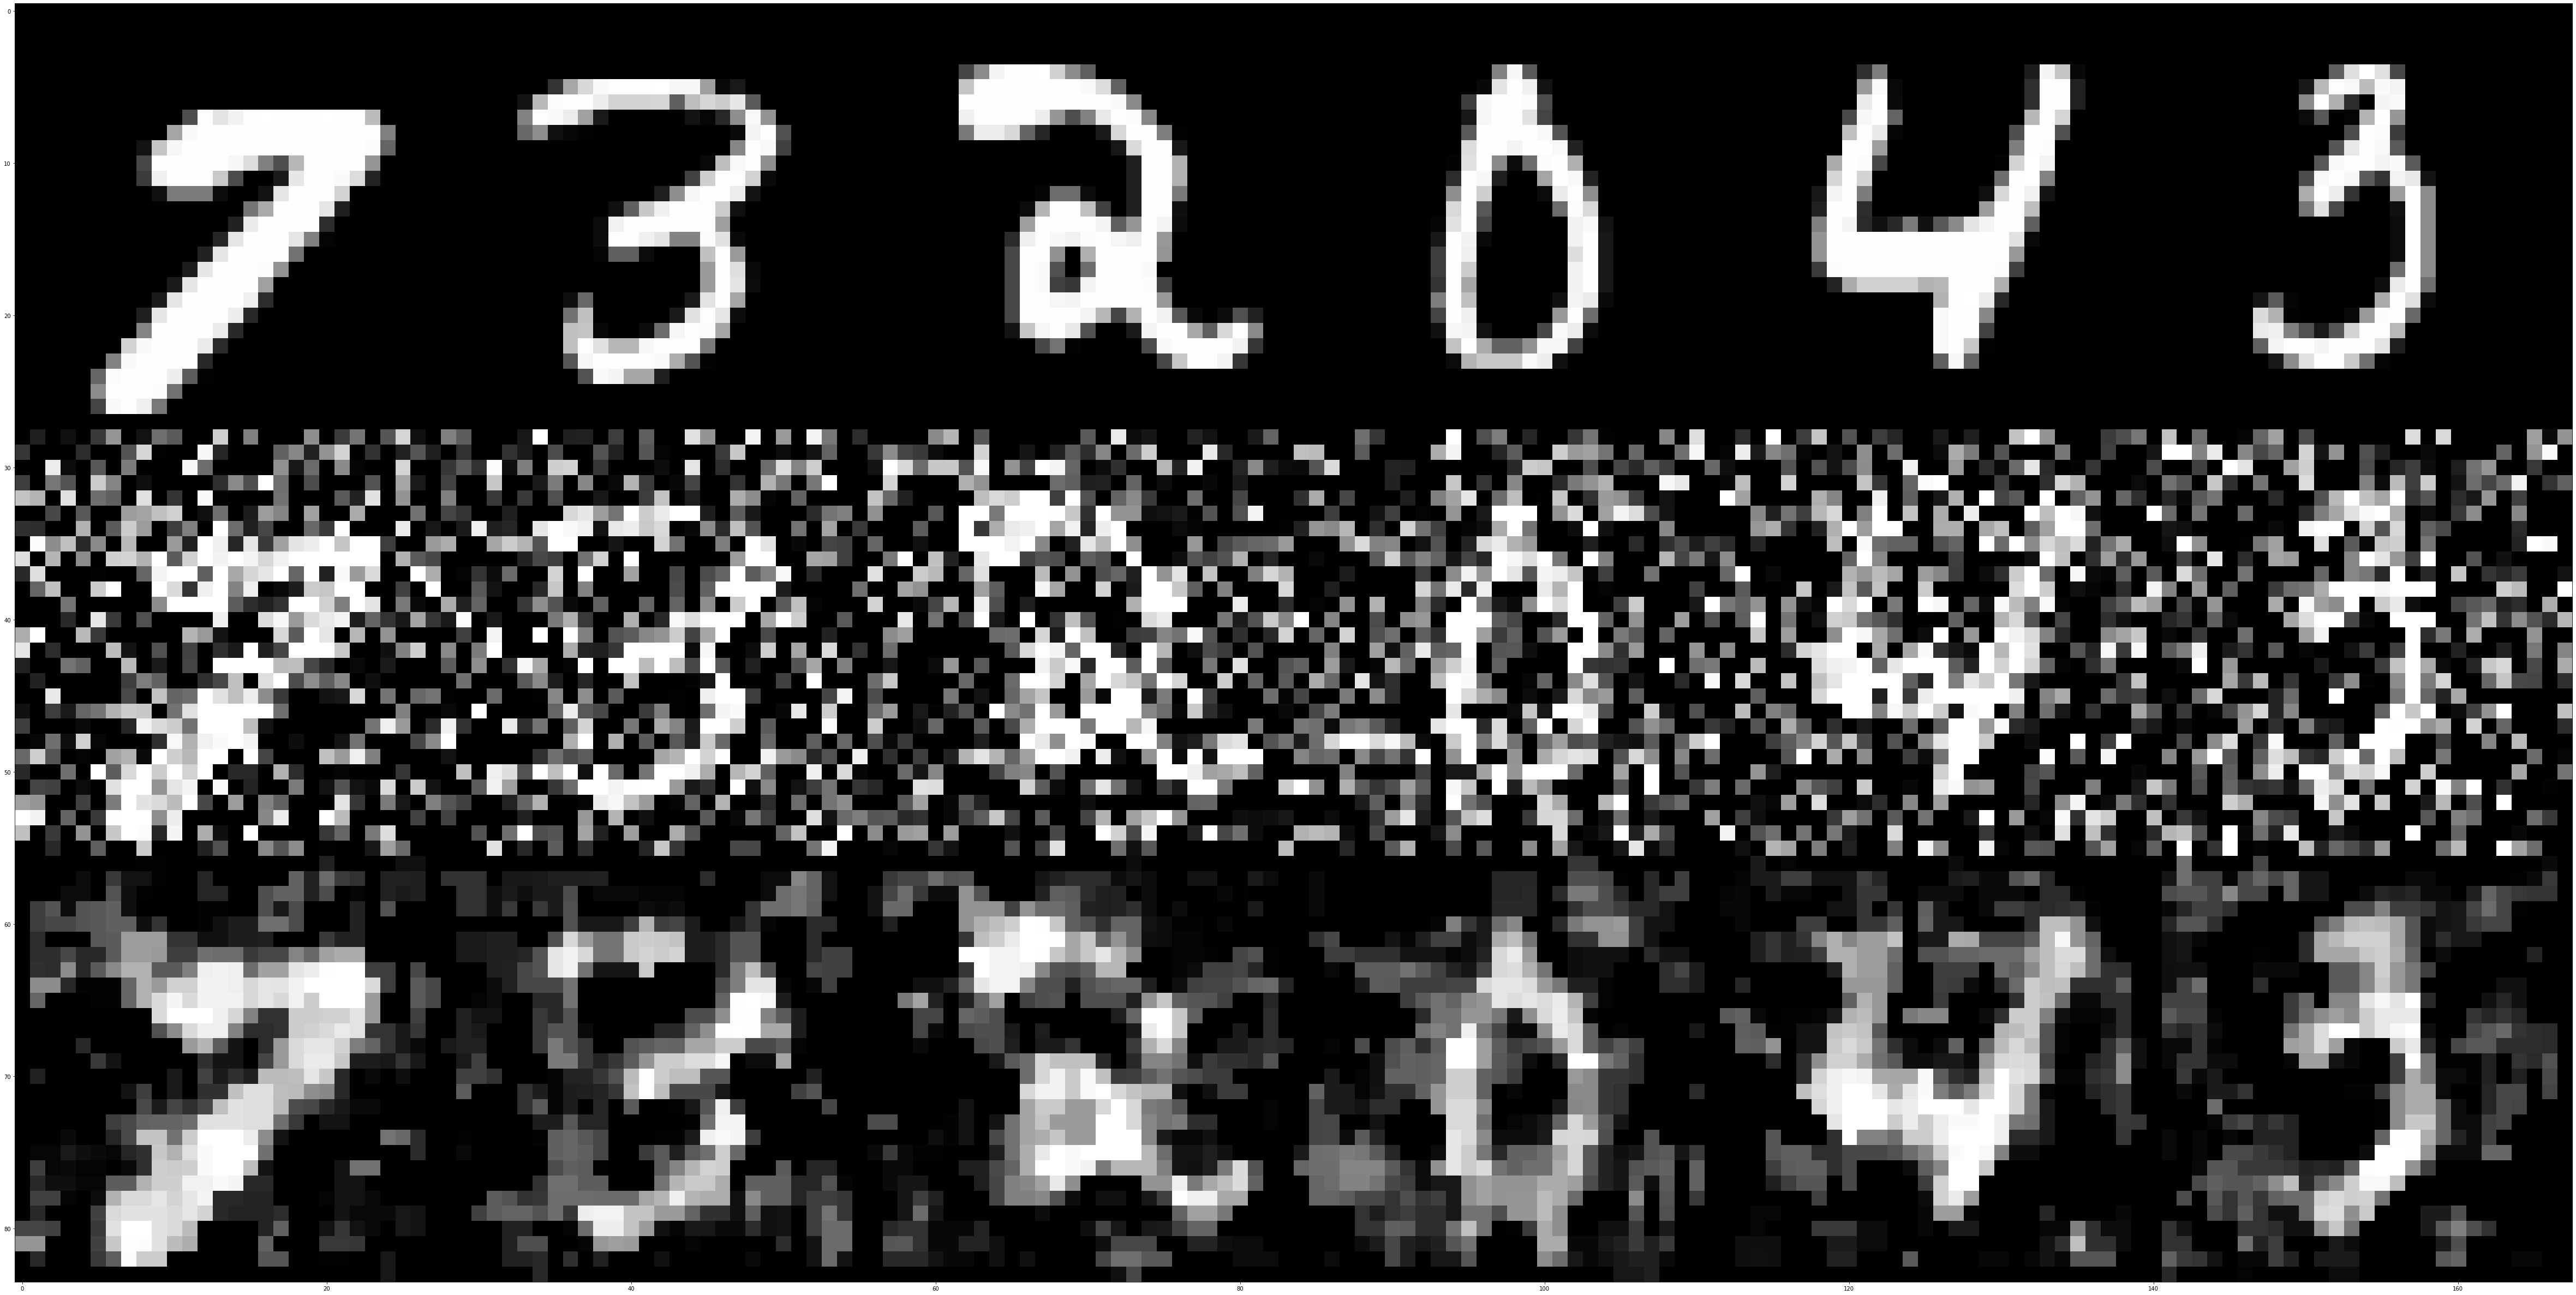

In [5]:
num_train = 50000
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# 模型构建

编码器模型

In [6]:
#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
#重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

解码器模型

In [ ]:
#decoder part
# we instantiate these layers xc separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)

变分自编码器总模型及参数

In [7]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

模型结构图

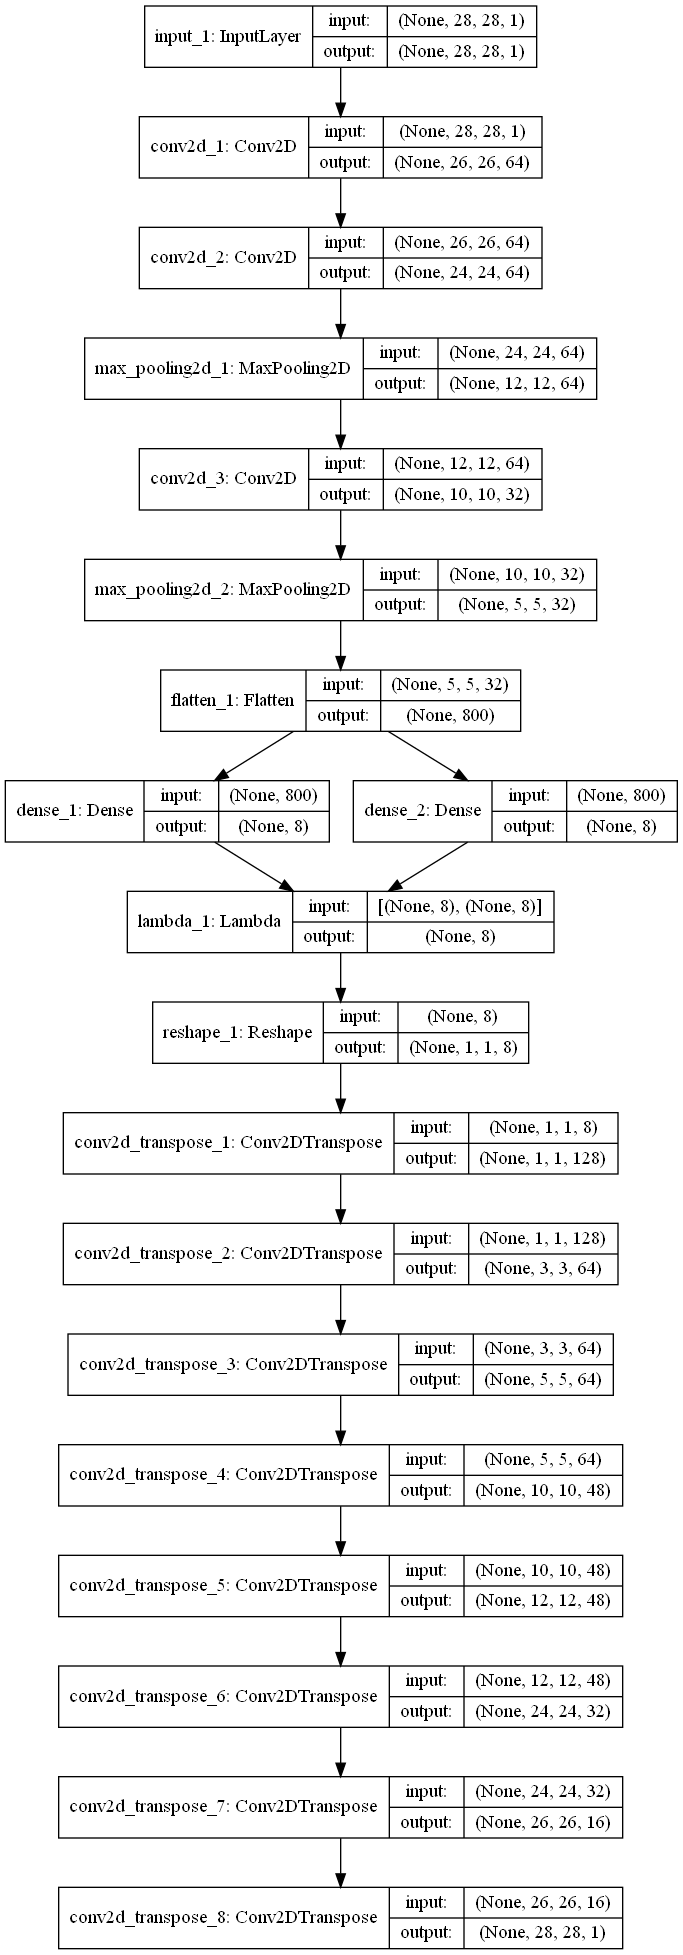

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(vae, to_file='model1.png',show_shapes=True)

# 变分自编码器损失函数

In [10]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

编译模型

In [ ]:
vae.compile(optimizer='adam', loss=VAE_loss)

# 训练模型

In [11]:
history = vae.fit(noise_train,x_train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(noise_test, x_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 401s 7ms/step - loss: 231.7357 - val_loss: 165.9350
Epoch 2/3
60000/60000 [==============================] - 493s 8ms/step - loss: 147.5553 - val_loss: 136.1280
Epoch 3/3
60000/60000 [==============================] - 445s 7ms/step - loss: 133.6167 - val_loss: 130.9588


损失可视化

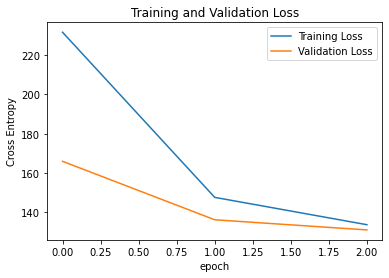

In [59]:

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


保存模型和history

In [ ]:
#保存模型权重
#保存训练细节
# vae.save('vae.h5')

# #保存history
# import pickle
# with open('result_test.pickle', 'wb') as file_pi:
# 	pickle.dump(history.history, file_pi)

加载模型和history

In [ ]:
# 加载模型权重
# 加载训练细节
# model.load_weights("vi_128_lrdefault.hdf5")
# import pickle
# with open('model_vi_bs_128_lrdefault_hist.pickle', 'rb') as f:
#     history = pickle.load(f)

# 测试

In [13]:
digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))

0 8545
1 5643
2 5408
3 5760
4 302
5 5558


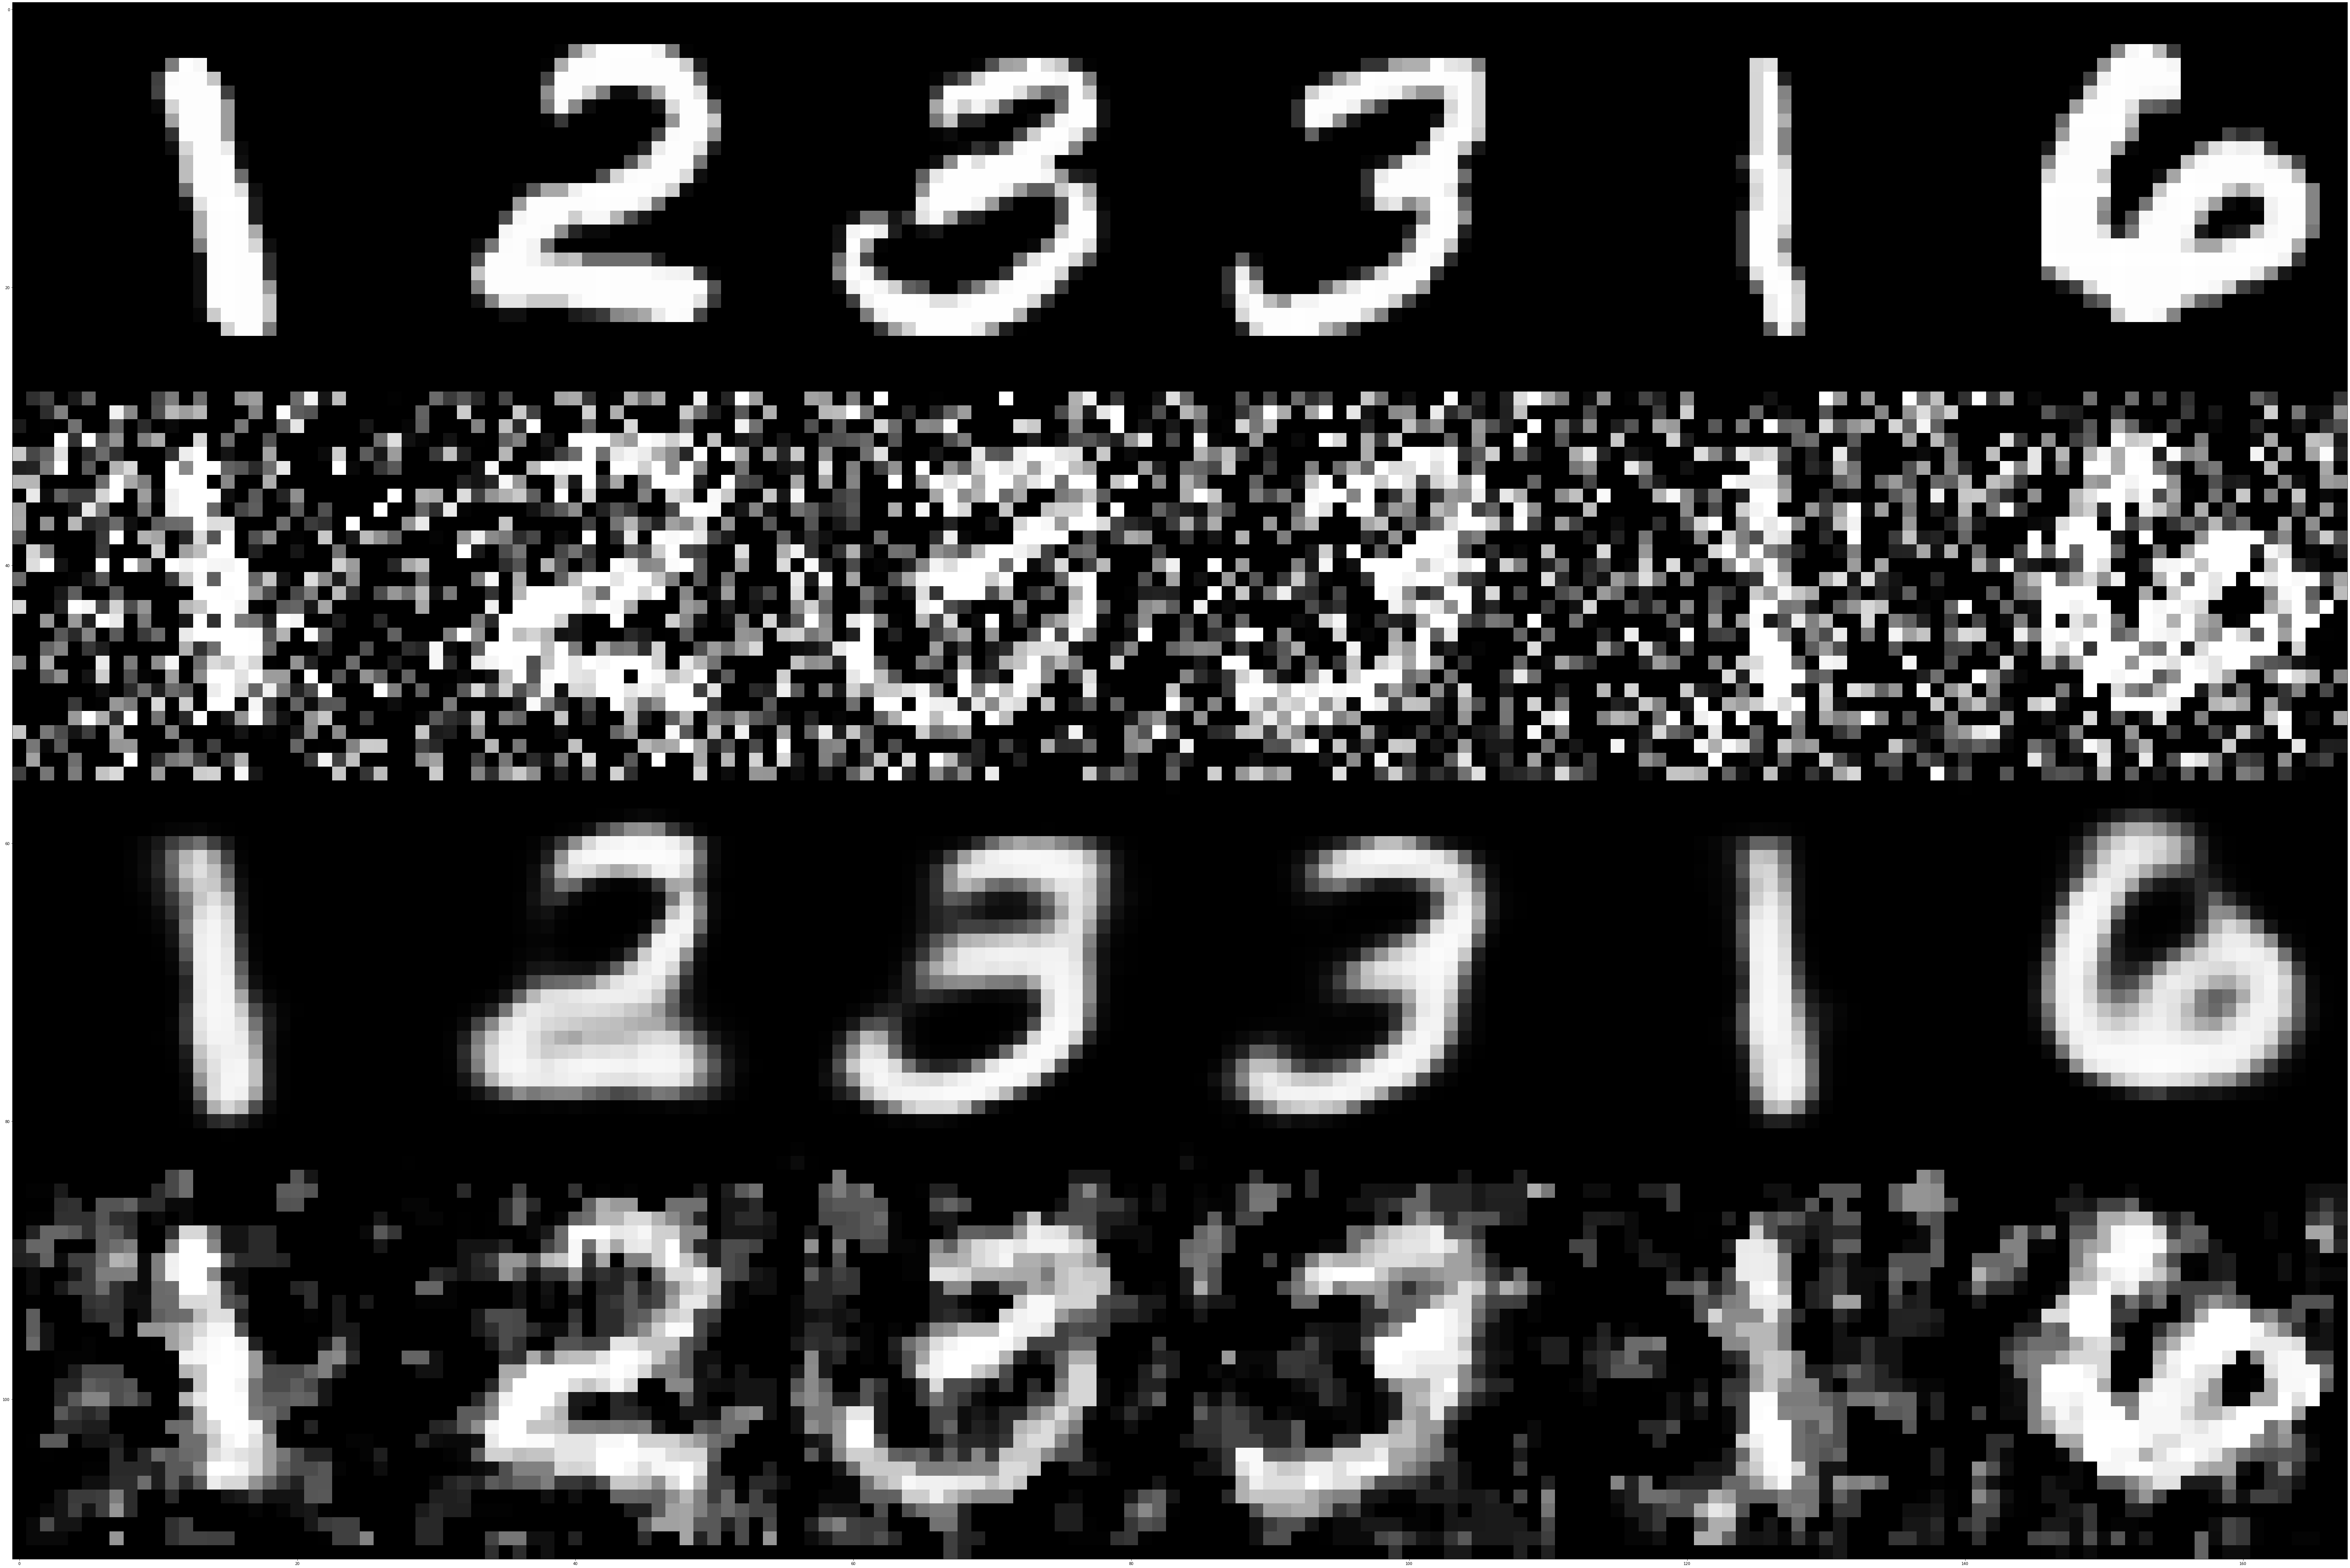

In [29]:
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(x_test[showidx])
# Display
for i,idx in enumerate (showidx):
    print(i,idx)
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_VAE.png')
plt.show()

### PSNR计算

定义psnr函数

In [27]:
import cv2
import numpy as np
import math
 
def psnr1(img1, img2):
   mse = np.mean((img1 - img2) ** 2 )
   if mse < 1.0e-10:
      return 100
   return 10 * math.log10(255.0**2/mse)
#法2
def psnr2(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


In [35]:
#pip install pandas

  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)



计算并展示、保存

In [49]:
import pandas as pd
data = {}
for i,idx in enumerate (showidx):
    gt = np.reshape(x_test[idx], [28, 28])
    img_noise = np.reshape(noise_test[idx], [28, 28])
    img_out = np.reshape(x_out[i], [28, 28])
    img_medfilter = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
    
    psnr_noise = psnr1(gt,img_noise)
    psnr_out = psnr1(gt,img_out)
    psnr_medfilter = psnr1(gt,img_medfilter)
    column = 'idx_' + str(idx)
    data[column] = [psnr_noise,psnr_out,psnr_medfilter]
df = pd.DataFrame(data, index = ["psnr_noise","psnr_out","psnr_medfilter"])

In [56]:
print(df)
df.to_csv("psnr_result.csv")

                 idx_8545   idx_5643   idx_5408   idx_5760    idx_302  \
psnr_noise      57.417035  57.466789  57.508579  57.232839  57.249058   
psnr_out        66.631475  62.031316  62.816202  64.206717  69.995612   
psnr_medfilter  63.634083  63.040098  62.393184  62.824459  62.528574   

                 idx_5558  
psnr_noise      57.505364  
psnr_out        63.080356  
psnr_medfilter  62.831259  


### SSIM计算

ssim函数定义

In [78]:
#// An highlighted block
import cv2
import numpy as np
def ssim(img1, img2):
  C1 = (0.01 * 255)**2
  C2 = (0.03 * 255)**2
  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  kernel = cv2.getGaussianKernel(11, 1.5)
  window = np.outer(kernel, kernel.transpose())
  mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5] # valid
  mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
  mu1_sq = mu1**2
  mu2_sq = mu2**2
  mu1_mu2 = mu1 * mu2
  sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
  sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
  sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
  ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                              (sigma1_sq + sigma2_sq + C2))
  return ssim_map.mean()
def calculate_ssim(img1, img2):
  '''calculate SSIM
  the same outputs as MATLAB's
  img1, img2: [0, 255]
  '''
  if not img1.shape == img2.shape:
    raise ValueError('Input images must have the same dimensions.')
  if img1.ndim == 2:
    return ssim(img1, img2)
  elif img1.ndim == 3:
    if img1.shape[2] == 3:
      ssims = []
      for i in range(3):
        ssims.append(ssim(img1, img2))
      return np.array(ssims).mean()
    elif img1.shape[2] == 1:
      return ssim(np.squeeze(img1), np.squeeze(img2))
  else:
    raise ValueError('Wrong input image dimensions.')


计算SSIM并展示、保存

In [68]:
import pandas as pd
data = {}
for i,idx in enumerate (showidx):
    gt = np.reshape(x_test[idx], [28, 28])
    img_noise = np.reshape(noise_test[idx], [28, 28])
    img_out = np.reshape(x_out[i], [28, 28])
    img_medfilter = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
    
    psnr_noise = calculate_ssim(gt,img_noise)
    psnr_out = calculate_ssim(gt,img_out)
    psnr_medfilter = calculate_ssim(gt,img_medfilter)
    column = 'idx_' + str(idx)
    data[column] = [psnr_noi se,psnr_out,psnr_medfilter]
df2 = pd.DataFrame(data, index = ["ssim_noise","ssim_out","ssim_medfilter"])
print(df2)
df2.to_csv("ssim_result.csv")

                idx_8545  idx_5643  idx_5408  idx_5760   idx_302  idx_5558
ssim_noise      0.993288  0.996376  0.996817  0.995925  0.992374  0.996417
ssim_out        0.998617  0.995930  0.997468  0.998346  0.999436  0.997587
ssim_medfilter  0.997554  0.998499  0.998329  0.998211  0.997024  0.998627
